### Midterm project - Kaggle exercise project

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goals

* Get familar with Kaggle competition since our final project may be a real Kaggle competition.
* Practice on large data set
* Data quality checking, missing data imputation
* Feature selection. What's your rationals to choose those features.
* Create at least 5 new features and explain your reason for every new features.
* Use feature importance to help you choose 10 features
* Choose 3 ML algorithms we covered in the class to build your prediction models
* For each model you build, you will need to evaluate and show your effort to improve it.
* Your jupyter submission should be in an article quality. Do NOT print huge data set in the notebook. Use head(). Use plotting to visualize your analysis and results. Use markdown to write your comments.
* Your score is based on completeness on every step.
* Submit in HTML and ipynb format on canvas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import datetime
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale
from IPython.display import clear_output
# import warnings
# warnings.filterwarnings('ignore')

We are first going to load the training dataset on a Pandas Dataframe and do some initial cleansing. We will keep this initial cleansed dataset throughout the entire analysis as the baseline for other transformations and evaluations

In [2]:
train_dataset = pd.read_csv("train.csv")
train_dataset.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


The first transformation that we are going to apply to the dataset is to set the Id column as the index. One of the reasons is for not have to remove it everytime that we need to do an analysis on features. Another one is that it will be used to join with other Dataframes.

In [3]:
train_dataset.set_index("Id", inplace=True)

Now, we take a look on our dataset to understand a little bit of the columns/features and their content.

In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Next step is to deal with the null values. Variables with too much null values will not contribute much to the model and can even reduce the performance. Also, it is hard to fill them using any method, because we will be creating biases anyway.

In [5]:
null_percentage_per_column = train_dataset.isnull().sum() / len(train_dataset) * 100
null_percentage_per_column[null_percentage_per_column > 0]

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

There are four columns (Alley, PoolQC, Fence and MiscFeature) with too much null values (we are considering a threshold of 50%). We are going to remove them from our dataset.

In [6]:
train_dataset = train_dataset.drop(["Alley", "PoolQC", "Fence", "MiscFeature"], axis=1)

Now let's take a look on some of the remaining columns with null values to decide the best strategy for each one of them, starting with LotFrontage, which is the linear feet of street connected to property.

As we will do the same analysis for other columns, let's create a function that provide the same info.

In [7]:
def check_column_statistics(dataset, column):
    print(
        "\nTotal rows:", len(dataset),
        "\nTotal rows with values:", dataset[column].count(),
        "\nTotal rows with no values:", dataset[column].isnull().sum(),
        "\n% of rows with no values:", round(dataset[column].isnull().sum() / len(dataset) * 100, 2),
        "\nSamples values:", list(dataset[column].drop_duplicates().head(10))
    )
    if str(dataset[column].dtypes) == "object":
        print("Mode:", dataset[column].mode()[0])
    else:
        print(
            "Median:", dataset[column].median(),
            "\nMean:", dataset[column].mean()
        )

In [8]:
check_column_statistics(train_dataset, "LotFrontage")


Total rows: 1460 
Total rows with values: 1201 
Total rows with no values: 259 
% of rows with no values: 17.74 
Samples values: [65.0, 80.0, 68.0, 60.0, 84.0, 85.0, 75.0, nan, 51.0, 50.0]
Median: 69.0 
Mean: 70.04995836802665


Although we have only integer values on LotFrontage column, it seems to be a continuous variable (probably it is being rounded). We have less than 20% empty. Based on the description of the measure and the data it holds, we can use one of the centrality measures to fill up the gaps and for this case we will use the median. 

In [9]:
train_dataset["LotFrontage"].fillna(train_dataset["LotFrontage"].median(), inplace=True)

As we are going to use the code to check the percentage of records with null values a couple more times, let's create a function for it.

In [10]:
def check_null_values(dataset):
    null_percentage_per_column = dataset.isnull().sum()/len(dataset)*100
    print(null_percentage_per_column[null_percentage_per_column > 0])

In [11]:
check_null_values(train_dataset)

MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64


Next column is MasVnrType which is the Masonry veneer type for the property.

In [12]:
check_column_statistics(train_dataset, "MasVnrType")


Total rows: 1460 
Total rows with values: 1452 
Total rows with no values: 8 
% of rows with no values: 0.55 
Samples values: ['BrkFace', 'None', 'Stone', 'BrkCmn', nan]
Mode: None


For MasVnrType category column we are going to use the mode to fill them (and we will use the same logic for cases alike from now on)

In [13]:
train_dataset["MasVnrType"].fillna(train_dataset["MasVnrType"].mode()[0], inplace=True)
check_null_values(train_dataset)

MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
dtype: float64


We can create a loop to perform the same actions for the remaining columns, according to their types: 

* If categorial, use mode
* If numeric, use median

In [14]:
null_percentage_per_column = train_dataset.isnull().sum()/len(train_dataset)*100
for index, each in pd.DataFrame(null_percentage_per_column[null_percentage_per_column > 0]).iterrows():
    if str(train_dataset[index].dtypes) == "object":
        train_dataset[index].fillna(train_dataset[index].mode()[0], inplace=True)
    else:
        train_dataset[index].fillna(train_dataset[index].median(), inplace=True)

After we have executed, we can double check to be sure there is no longer any column with null values

In [15]:
check_null_values(train_dataset)

Series([], dtype: float64)


As we are going to use the same transformation on our test dataset, let's build a function to apply the same cleansing actions to any dataset.

In [16]:
def null_columns_transformation(dataset, train_set=True):
    # Set Id column as index
    if "Id" in dataset.columns:
        dataset.set_index("Id", inplace=True)
    
    null_percentage_per_column = dataset.isnull().sum() / len(dataset) * 100
    null_percentage_per_column = pd.DataFrame(
        null_percentage_per_column[null_percentage_per_column > 0],
        columns=["percentage_of_null"]
    )
    for index, each in null_percentage_per_column.iterrows():
        if each["percentage_of_null"] > .5 and train_set == True:
            dataset = dataset.drop([index], axis=1)
        elif str(dataset[index].dtypes) == "object":
            dataset[index].fillna(dataset[index].mode()[0], inplace=True)
        else:
            dataset[index].fillna(dataset[index].median(), inplace=True)
    return dataset

## First attempt

As our first attempt, we are going to use all remaining columns without any further transformation.

In [17]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

We still have 75 columns (features) and we need to reduce the number of features being used, first because using too many features can cause overfitting and second because it is costly to try out all of them. We are going to use Random Forest to select the most important features for the dataset.

In [18]:
train_first_attempt = train_dataset.iloc[:,:]

In [19]:
RFRegressor = RandomForestRegressor(random_state=1, max_depth=10)
train_first_attempt_dummy_features = pd.get_dummies(train_first_attempt.iloc[:,:-1])
RFRegressor.fit(train_first_attempt_dummy_features, train_first_attempt.iloc[:,-1])

RandomForestRegressor(max_depth=10, random_state=1)

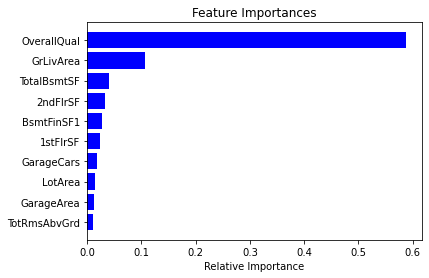

In [20]:
features = train_first_attempt_dummy_features.columns
importances = RFRegressor.feature_importances_
indexes = np.argsort(importances)[-10:]  # top 10 features
plt.title("Feature Importances")
plt.barh(range(len(indexes)), importances[indexes], color='b', align='center')
plt.yticks(range(len(indexes)), [features[i] for i in indexes])
plt.xlabel('Relative Importance')
plt.show()

As per the chart above, we can see that OverallQual is responsible for explaining almost 60% of the variance of our target variable. On the next plot we can see the cumulative variance being explained by the top 10 features.

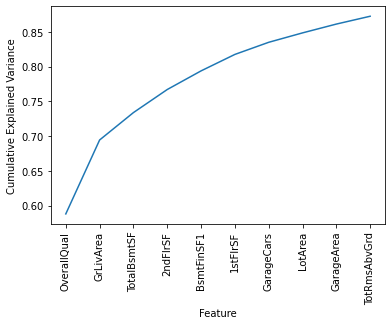

In [21]:
feature_ranking = pd.DataFrame(
    {"Feature": train_first_attempt_dummy_features.columns,
     "Weight": RFRegressor.feature_importances_
    }
)
feature_ranking = feature_ranking.sort_values(by=["Weight"], ascending=False).reset_index()
feature_ranking = feature_ranking.drop(["index"], axis=1)
top_features = feature_ranking.head(10)
plt.plot(top_features["Feature"], np.cumsum(top_features["Weight"]))
plt.xticks(top_features["Feature"], top_features["Feature"], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Cumulative Explained Variance');

To evaluate our current dataset for several models and combinations of features, we will create a function to perform the evaluation.

We will try with three regression models:

* Linear Regression
* Decision Tree Regression
* Support Vector Machine Regression (we are going to test the three kernel)

In [22]:
def evaluate_models(data_frame, features, target_column, initial_number_of_features = 1, 
                    max_number_of_features = 1):
    evaluation_list = []
    counter = 0
    for number_of_features in range(initial_number_of_features, max_number_of_features + 1):
        for each_combination_of_features in list(itertools.combinations(features, r=number_of_features)):
            print("Features:", list(each_combination_of_features))
            X = data_frame[list(each_combination_of_features)]
            y = data_frame[target_column]
            
            regressor = LinearRegression()
            model = "LinearRegression"
            scores = cross_validate(regressor, X, y, scoring=("r2", "neg_mean_squared_error"))
            evaluation_item = {
                "Features": list(each_combination_of_features),
                "Model": model,
                "MSE": np.sqrt(- np.mean(scores["test_neg_mean_squared_error"]))
            }
            evaluation_list.append(evaluation_item)

            regressor = DecisionTreeRegressor()
            model = "DecisionTreeRegressor"
            scores = cross_validate(regressor, X, y, scoring=('r2', 'neg_mean_squared_error'))
            evaluation_item = {
                "Features": list(each_combination_of_features),
                "Model": model,
                "MSE": np.sqrt(- np.mean(scores["test_neg_mean_squared_error"]))
            }
            evaluation_list.append(evaluation_item)
            
            kernels = [
                SVR(kernel="linear", gamma="scale"), 
                SVR(kernel='poly', gamma="scale"), 
                SVR(kernel="rbf", gamma="scale")
            ]
            for each_kernel in ["linear", "poly", "rbf"]:
                regressor = SVR(kernel=each_kernel, gamma="scale")
                model = "SVM (" + each_kernel + ")"
                scores = cross_validate(regressor, X, y, scoring=('r2', 'neg_mean_squared_error'))
                evaluation_item = {
                    "Features": list(each_combination_of_features),
                    "Model": model,
                    "MSE": np.sqrt(- np.mean(scores["test_neg_mean_squared_error"]))
                }
                evaluation_list.append(evaluation_item) 
            clear_output(wait=True)
            counter += 5
    print("Total of evaluations:", counter)    
    return pd.DataFrame(evaluation_list)

As our 3 top features explain over 70% of our variability, we will start with them. Also, we are going to use Mean Squared Error (MSE) as the measure to compare the performance of our model.

In [23]:
first_attempt_evaluation = evaluate_models(
    data_frame = train_first_attempt, 
    features = list(top_features["Feature"].head(3)),
    target_column = "SalePrice",
    initial_number_of_features = 1,
    max_number_of_features = 3
)
(first_attempt_evaluation.sort_values(by=["MSE"])).iloc[0:5,:]

Total of evaluations: 35


,Features,Model,MSE
30,"[OverallQual, GrLivArea, TotalBsmtSF]",LinearRegression,41173.349591
15,"[OverallQual, GrLivArea]",LinearRegression,42791.484493
31,"[OverallQual, GrLivArea, TotalBsmtSF]",DecisionTreeRegressor,44212.608311
1,[OverallQual],DecisionTreeRegressor,45114.652856
3,[OverallQual],SVM (poly),45266.150285


According to our evaluation, Linear Regression using the three features was the configuration that obtained the best score. We are now then predict our test set using it and then submit to get the score. As we are going to use the same steps from now on, let's also create a function for it

In [24]:
def generate_predictions(evaluations, train_set, test_set):
    choosen_features = (evaluations.sort_values(by=["MSE"])).iloc[0]["Features"]
    choosen_model = (evaluations.sort_values(by=["MSE"])).iloc[0]["Model"]
    
    X = np.array(train_set[choosen_features])
    y = train_set["SalePrice"]
    
    if choosen_model == "LinearRegression":
        regressor = LinearRegression()
    elif choosen_model == "DecisionTreeRegressor":
        regressor = DecisionTreeRegressor()
    elif choosen_model == "SVM (linear)":
        regressor = SVR(kernel="linear", gamma="scale")
    elif choosen_model == "SVM (poly)":
        regressor = SVR(kernel='poly', gamma="scale")
    elif choosen_model == "SVM (rbf)":
        regressor = SVR(kernel="rbf", gamma="scale")
    regressor.fit(X, y) 
    predictions = regressor.predict(test_set[choosen_features])
    return predictions

In [25]:
test_set = pd.read_csv("test.csv")
test_set["SalePrice"] = 0 ## Adding a dummy target variable
test_set = null_columns_transformation(test_set, train_set=False)

prediction_set = generate_predictions(first_attempt_evaluation, train_first_attempt, test_set)
pd.DataFrame(prediction_set).head()

,0
0,113031.557672
1,178858.174490
2,150964.626164
3,177701.795711
4,230734.290431


Also, let's create a function that generates our submission file

In [26]:
def generate_submission(test_set, predictions, name):
    initial_index = test_set.index[0]
    submission = pd.DataFrame({'SalePrice': prediction_set}).reset_index()
    submission["Id"] = submission["index"] + initial_index

    file_name = (
        "submission_" + name + "_" + datetime.datetime.today().strftime('%Y%m%d') + 
        '_' + datetime.datetime.today().strftime('%H%M%S') + "csv"
    )
    submission[["Id", "SalePrice"]].to_csv(file_name, index=False)    

In [27]:
generate_submission(test_set, prediction_set, "1st_attempt")

The score obtained with the first attempt was 0.87504, which would put us around position 4200 on the Kaggle leaderboard. 

## Second Attempt

On our second attempt we are trying to remove the columns with low variance. Let's first take a look on them.

In [28]:
train_second_attempt = train_dataset.iloc[:,:]
train_second_attempt.var(numeric_only=True).astype(str)

MSSubClass          1789.338306402389
LotFrontage          485.218557935159
LotArea              99625649.6503417
OverallQual        1.9126794482991698
OverallCond        1.2383223637883065
YearBuilt           912.2154126019892
YearRemodAdd        426.2328222558136
MasVnrArea         32663.829315912957
BsmtFinSF1         208025.46846873628
BsmtFinSF2         26023.907778831064
BsmtUnfSF           195246.4061794061
TotalBsmtSF         192462.3617090893
1stFlrSF           149450.07920371392
2ndFlrSF            190557.0753373038
LowQualFinSF       2364.2040480906326
GrLivArea          276129.63336259616
BsmtFullBath      0.26926821711248283
BsmtHalfBath      0.05700282610532444
FullBath          0.30350822011698775
HalfBath           0.2528937065169486
BedroomAbvGr        0.665493817307771
KitchenAbvGr     0.048548921667120055
TotRmsAbvGrd       2.6419033490756916
Fireplaces        0.41559474964087506
GarageYrBlt          575.857042260131
GarageCars         0.5584797243373708
GarageArea  

The columns with lowest variance are related to the number of rooms of the house (number of full baths, of bedrooms above ground, etc.). We can use a threshold of < 1 to remove all of them. Again, as we may need to do the same cleansing in next attemps, let's create a function for it

In [29]:
def remove_low_variance_features(data_set, threshold):
    numeric_features = data_set.iloc[:,:-1].select_dtypes([np.number]).columns
    for each_feature in numeric_features:
        if data_set[each_feature].var() < threshold:
            data_set = data_set.drop(each_feature, axis=1)
    return data_set

In [30]:
train_second_attempt = remove_low_variance_features(train_second_attempt, 1)

In [31]:
train_second_attempt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

We could reduce the number of features/dimensions from 75 to 67 with this transformation. Let's use Decision Tree regressor again to see how this affected the importance of the remaining features.

In [32]:
RFRegressor = RandomForestRegressor(random_state=1, max_depth=10)
train_second_attempt_dummy_features = pd.get_dummies(train_second_attempt.iloc[:,:-1])
RFRegressor.fit(train_second_attempt_dummy_features, train_second_attempt.iloc[:,-1])

RandomForestRegressor(max_depth=10, random_state=1)

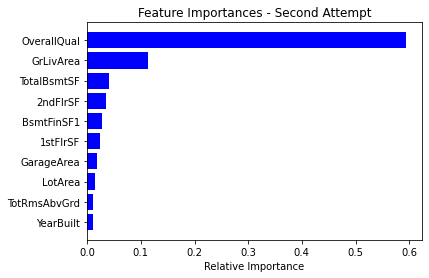

In [33]:
features = train_second_attempt_dummy_features.columns
importances = RFRegressor.feature_importances_
indexes = np.argsort(importances)[-10:]  # top 10 features
plt.title("Feature Importances - Second Attempt")
plt.barh(range(len(indexes)), importances[indexes], color='b', align='center')
plt.yticks(range(len(indexes)), [features[i] for i in indexes])
plt.xlabel('Relative Importance')
plt.show()

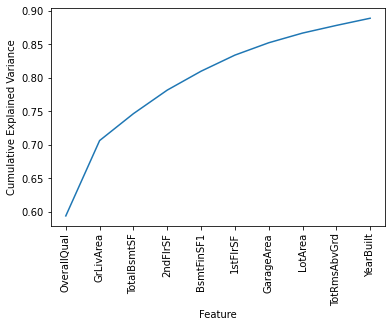

In [34]:
feature_ranking = pd.DataFrame(
    {"Feature": train_second_attempt_dummy_features.columns,
     "Weight": RFRegressor.feature_importances_
    }
)
feature_ranking = feature_ranking.sort_values(by=["Weight"], ascending=False).reset_index()
feature_ranking = feature_ranking.drop(["index"], axis=1)
top_features = feature_ranking.head(10)
plt.plot(top_features["Feature"], np.cumsum(top_features["Weight"]))
plt.xticks(top_features["Feature"], top_features["Feature"], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Cumulative Explained Variance');

Now our top 3 features are explaining almost 75% of the variance. Let try to run the same models but now with 4 features as the maximum features.

In [35]:
second_attempt_evaluation = evaluate_models(
    data_frame = train_second_attempt, 
    features = list(top_features["Feature"].head(4)),
    target_column = "SalePrice",
    initial_number_of_features = 1,
    max_number_of_features = 4
)
(second_attempt_evaluation.sort_values(by=["MSE"])).iloc[0:5,:]

Total of evaluations: 75


,Features,Model,MSE
70,"[OverallQual, GrLivArea, TotalBsmtSF, 2ndFlrSF]",LinearRegression,41136.951173
50,"[OverallQual, GrLivArea, TotalBsmtSF]",LinearRegression,41173.349591
55,"[OverallQual, GrLivArea, 2ndFlrSF]",LinearRegression,41348.028552
20,"[OverallQual, GrLivArea]",LinearRegression,42791.484493
61,"[OverallQual, TotalBsmtSF, 2ndFlrSF]",DecisionTreeRegressor,42848.925268


We could reduce our MSE from 41173.35 to 41136.95 on our second attempt, still with Linear Regression and the max number of features evaluated (4). Not much, but let's generate predictions and submit again to see how it is scored in Kaggle.

In [36]:
test_set = pd.read_csv("test.csv")
test_set["SalePrice"] = 0 ## Adding a dummy target variable
test_set = null_columns_transformation(test_set, train_set=False)

prediction_set = generate_predictions(second_attempt_evaluation, train_second_attempt, test_set)
pd.DataFrame(prediction_set).head()

,0
0,112447.853724
1,179167.409571
2,148399.824985
3,175549.538253
4,231675.212784


In [37]:
generate_submission(test_set, prediction_set, "2nd_attempt")

The score on submission also presented litle improvement: with 0.87140 points it would put us still around the position 4200 on the leaderboard.

## Third attempt

On our third attempt, besides removing columns with low variance, we are going also to standardize all numeric columns.

In [38]:
train_third_attempt = train_dataset.iloc[:,:]
train_third_attempt = remove_low_variance_features(train_third_attempt, 1)

In [39]:
def standardize_numeric_features(data_set):
    numeric_features = data_set.iloc[:,:-1].select_dtypes([np.number]).columns
    initial_index = data_set.index[0]
    std_metrics = data_set.loc[:, numeric_features].values
    std_metrics = pd.DataFrame(StandardScaler().fit_transform(std_metrics), columns=numeric_features).reset_index()
    std_metrics["index"] = std_metrics["index"] + initial_index
    std_metrics.set_index("index", inplace=True)
    remaining_columns = data_set.drop(numeric_features, axis=1)
    remaining_columns = data_set.iloc[:,-1]
    standardized_dataset = pd.merge(std_metrics, remaining_columns, left_index=True, right_index=True)
    return standardized_dataset

In [40]:
train_third_attempt = standardize_numeric_features(train_third_attempt)
train_third_attempt.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
index,,,,,,,,,,,,,,,,,,,,,
1,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,208500
2,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,181500
3,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,223500
4,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,140000
5,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,250000


And again we are going to use our Random Forest Regressor to check the importance of features

In [41]:
RFRegressor = RandomForestRegressor(random_state=1, max_depth=10)
train_third_attempt_dummy_features = pd.get_dummies(train_third_attempt.iloc[:,:-1])
RFRegressor.fit(train_third_attempt_dummy_features, train_third_attempt.iloc[:,-1])

RandomForestRegressor(max_depth=10, random_state=1)

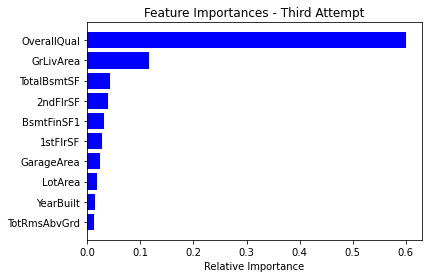

In [42]:
features = train_third_attempt_dummy_features.columns
importances = RFRegressor.feature_importances_
indexes = np.argsort(importances)[-10:]  # top 10 features
plt.title("Feature Importances - Third Attempt")
plt.barh(range(len(indexes)), importances[indexes], color='b', align='center')
plt.yticks(range(len(indexes)), [features[i] for i in indexes])
plt.xlabel('Relative Importance')
plt.show()

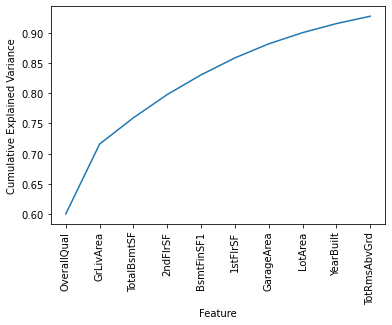

In [43]:
feature_ranking = pd.DataFrame(
    {"Feature": train_third_attempt_dummy_features.columns,
     "Weight": RFRegressor.feature_importances_
    }
)
feature_ranking = feature_ranking.sort_values(by=["Weight"], ascending=False).reset_index()
feature_ranking = feature_ranking.drop(["index"], axis=1)
top_features = feature_ranking.head(10)
plt.plot(top_features["Feature"], np.cumsum(top_features["Weight"]))
plt.xticks(top_features["Feature"], top_features["Feature"], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Cumulative Explained Variance');

Not changed from the previous configuration. However, let's evaluate the model with one additional feature and now with the stardardized columns and check what happens.

In [44]:
third_attempt_evaluation = evaluate_models(
    data_frame = train_third_attempt, 
    features = list(top_features["Feature"].head(5)),
    target_column = "SalePrice",
    initial_number_of_features = 1,
    max_number_of_features = 5
)
(third_attempt_evaluation.sort_values(by=["MSE"])).iloc[0:5,:]

Total of evaluations: 155


,Features,Model,MSE
151,"[OverallQual, GrLivArea, TotalBsmtSF, 2ndFlrSF...",DecisionTreeRegressor,40225.969342
135,"[OverallQual, GrLivArea, 2ndFlrSF, BsmtFinSF1]",LinearRegression,40270.381600
150,"[OverallQual, GrLivArea, TotalBsmtSF, 2ndFlrSF...",LinearRegression,40404.604456
130,"[OverallQual, GrLivArea, TotalBsmtSF, BsmtFinSF1]",LinearRegression,40414.908054
85,"[OverallQual, GrLivArea, BsmtFinSF1]",LinearRegression,40738.318380


We could reduce our MSE from 41136.95 to 40225.96. Still not much increase, but at least it increased more than when compared with our previous attempt and now the model with best performance was Decision Tree Regressor. Let's again generate and submit to Kaggle to see how it is evaluated there.

In [45]:
test_set = pd.read_csv("test.csv")
test_set["SalePrice"] = 0 ## Adding a dummy target variable
test_set = null_columns_transformation(test_set)
test_set = standardize_numeric_features(test_set)

prediction_set = generate_predictions(third_attempt_evaluation, train_third_attempt, test_set)
pd.DataFrame(prediction_set).head()

,0
0,100000.0
1,196000.0
2,152000.0
3,192000.0
4,192000.0


In [46]:
generate_submission(test_set, prediction_set, "3rd_attempt")

0.23260 was way better than our second attempt (0.87140), but would still put us around position 3700 on leaderboard. A good improvement from one attemp to another. 

## Fourth attempt

For our fourth attemp, besides removing low variance columns and standardize every numeric variable, we are going also to twerk some parameters on models being attempted, as below:

* Linear Regression: forcing coeficients to be positive (positive=True)
* Decision Tree Regression: limiting the depth of our tree (max_depth=10) and also "pin" our randomness (random_state=1)
* Support Vector Machine Regression: increase the regularization parameter (C=2)


To start we will be loading a new DataFrame for this attempt, then re-define our function used to generate estimates as well our function to generate the predictions (it also also should consider the parameters above).

We do not need to reasses the most important features, as we will be using the same transformations from our third attempt.

In [47]:
train_fourth_attempt = train_dataset.iloc[:,:]
train_fourth_attempt = remove_low_variance_features(train_fourth_attempt, 1)
train_fourth_attempt = standardize_numeric_features(train_fourth_attempt)
train_fourth_attempt.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
index,,,,,,,,,,,,,,,,,,,,,
1,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,208500
2,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,181500
3,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,223500
4,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,140000
5,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,250000


In [48]:
def evaluate_models(data_frame, features, target_column, initial_number_of_features = 1, 
                    max_number_of_features = 1):
    evaluation_list = []
    counter = 0
    for number_of_features in range(initial_number_of_features, max_number_of_features + 1):
        for each_combination_of_features in list(itertools.combinations(features, r=number_of_features)):
            print("Features:", list(each_combination_of_features))
            X = data_frame[list(each_combination_of_features)]
            y = data_frame[target_column]
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2210)
            
            regressor = LinearRegression(positive=True)
            model = "LinearRegression"
            scores = cross_validate(regressor, X, y, scoring=('r2', 'neg_mean_squared_error'))

            evaluation_item = {
                "Features": list(each_combination_of_features),
                "Model": model,
                "MSE": np.sqrt(- np.mean(scores["test_neg_mean_squared_error"]))
            }
            evaluation_list.append(evaluation_item)

            regressor = DecisionTreeRegressor(max_depth=10, random_state=1)
            model = "DecisionTreeRegressor"
            scores = cross_validate(regressor, X, y, scoring=('r2', 'neg_mean_squared_error'))
            evaluation_item = {
                "Features": list(each_combination_of_features),
                "Model": model,
                "MSE": np.sqrt(- np.mean(scores["test_neg_mean_squared_error"]))
            }
            evaluation_list.append(evaluation_item)
            
            kernels = [
                SVR(kernel="linear", gamma="scale"), 
                SVR(kernel='poly', gamma="scale"), 
                SVR(kernel="rbf", gamma="scale")
            ]
            for each_kernel in ["linear", "poly", "rbf"]:
                regressor = SVR(kernel=each_kernel, gamma="scale", C=2)
                model = "SVM (" + each_kernel + ")"
                scores = cross_validate(regressor, X, y, scoring=('r2', 'neg_mean_squared_error'))
                evaluation_item = {
                    "Features": list(each_combination_of_features),
                    "Model": model,
                    "MSE": np.sqrt(- np.mean(scores["test_neg_mean_squared_error"]))
                }
                evaluation_list.append(evaluation_item) 
            clear_output(wait=True)
            counter += 5
    print("Total of evaluations:", counter) 
    return pd.DataFrame(evaluation_list)

In [49]:
fourth_attempt_evaluation = evaluate_models(
    data_frame = train_fourth_attempt, 
    features = list(top_features["Feature"].head(5)),
    target_column = "SalePrice",
    initial_number_of_features = 1,
    max_number_of_features = 5
)
(fourth_attempt_evaluation.sort_values(by=["MSE"])).iloc[0:5,:]

Total of evaluations: 155


,Features,Model,MSE
151,"[OverallQual, GrLivArea, TotalBsmtSF, 2ndFlrSF...",DecisionTreeRegressor,38095.353761
136,"[OverallQual, GrLivArea, 2ndFlrSF, BsmtFinSF1]",DecisionTreeRegressor,40122.096939
126,"[OverallQual, GrLivArea, TotalBsmtSF, 2ndFlrSF]",DecisionTreeRegressor,40279.753869
130,"[OverallQual, GrLivArea, TotalBsmtSF, BsmtFinSF1]",LinearRegression,40414.908054
150,"[OverallQual, GrLivArea, TotalBsmtSF, 2ndFlrSF...",LinearRegression,40414.908054


We got a good improvement in relation to our last attempt: 38095.35 vs 40225.96. 

Now we re-define the function that generate the predictions to consider the same parameters as our evaluation.

In [50]:
def generate_predictions(evaluations, train_set, test_set):
    choosen_features = (evaluations.sort_values(by=["MSE"])).iloc[0]["Features"]
    choosen_model = (evaluations.sort_values(by=["MSE"])).iloc[0]["Model"]
    
    X = np.array(train_set[choosen_features])
    y = train_set["SalePrice"]
    
    if choosen_model == "LinearRegression":
        regressor = LinearRegression(positive=True)
    elif choosen_model == "DecisionTreeRegressor":
        regressor = DecisionTreeRegressor(max_depth=10, random_state=1)
    elif choosen_model == "SVM (linear)":
        regressor = SVR(kernel="linear", gamma="scale", C=2)
    elif choosen_model == "SVM (poly)":
        regressor = SVR(kernel='poly', gamma="scale", C=2)
    elif choosen_model == "SVM (rbf)":
        regressor = SVR(kernel="rbf", gamma="scale", C=2)
    regressor.fit(X, y) 
    predictions = regressor.predict(test_set[choosen_features])
    return predictions

In [51]:
test_set = pd.read_csv("test.csv")
test_set["SalePrice"] = 0 ## Adding a dummy target variable
test_set = null_columns_transformation(test_set, train_set=False)
test_set = standardize_numeric_features(test_set)

prediction_set = generate_predictions(fourth_attempt_evaluation, train_fourth_attempt, test_set)
pd.DataFrame(prediction_set).head()

,0
0,121243.396226
1,166773.421053
2,147000.000000
3,191890.000000
4,200666.666667


In [52]:
generate_submission(test_set, prediction_set, "4th_attempt")

The fourth attemp was scored with 0.21564 points (against 0.23260 of the third attempt) which made us climb around 100 positions on the leaderboard.

## Fifth attempt
 
On our fifth and last attempt we are going to apply other techniques for reducing the number of dimension and create additional features, as well evaluate for every combination up to 10 features, using the top 10 features after we have re-assessed using Random Forrest.

In [54]:
train_fifth_attempt = train_dataset.iloc[:,:]
train_fifth_attempt = remove_low_variance_features(train_fifth_attempt, 1)

Before standardize the numeric variables, we are going to convert some categorial variables into numeric ones. We have several categorical variables (as ExterQual and GarageQual) that, although are text and categorical, represent a ranking (or rating). We are going to convert them to numerical categories, according to their ranking, from the worst (low values) to the best (high values) in one unit intervals.

In [55]:
def replace_ranking_by_rate(dataset):
    rating_columns = [
        "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
        "HeatingQC", "KitchenQual", "GarageFinish", "GarageQual", "GarageCond"
    ]
    ranking_to_rating = pd.DataFrame(
        [
            ["NA", 0], ["Po", 1], ["Fa", 2], ["TA", 3], ["Gd", 4], ["Ex", 5],
            ["Unf", 1], ["LwQ", 2], ["Rec", 3], ["BLQ", 4], ["ALQ", 5], ["GLQ", 6],
            ["No", 1], ["Mn", 2], ["Av", 3],
            ["Unf", 1], ["RFn", 2], ["Fin", 3]
        ], columns=["label", "value"]
    )

    dataset = dataset.reset_index()
    for each_column in rating_columns:
        dataset[each_column] = pd.merge(
            dataset, ranking_to_rating, how="left", left_on=each_column, right_on="label"
        )["value"]
    return dataset.set_index("Id")

In [56]:
train_fifth_attempt = replace_ranking_by_rate(train_fifth_attempt)

Columns with high correlation may be performance killers when training a model, as they have will have close performance on explaining variance on our target variable when analyzed alone, but together they will compete for the level of explanation they have among all variables. 

We are going to drop one column from a pair with more than 0.5 of correlation. The criteria that we are going to use to pick which column from the pair we are going to drop is the one with less variance. So, our logic will be: if the correlation between two columns is greater than 0.5, drop the one with less variance.

In [57]:
numeric_features = train_fifth_attempt.iloc[:,:-1].select_dtypes([np.number]).columns
li = []
for each_pair in list(itertools.combinations(numeric_features, r=2)):
    corr = train_fifth_attempt[each_pair[0]].corr(train_fifth_attempt[each_pair[1]])
    if train_fifth_attempt[each_pair[0]].var() > train_fifth_attempt[each_pair[1]].var():
        column_to_drop = each_pair[1]
    else:
        column_to_drop = each_pair[0]
    li.append(
        {
            "Feature1": each_pair[0],
            "Feature2": each_pair[1],
            "Corr": abs(corr),
            "Drop Column": column_to_drop
        }
    )
correlation_list = pd.DataFrame(li)
correlation_list.sort_values(by=["Corr"], ascending=False).head(10)

,Feature1,Feature2,Corr,Drop Column
645,GrLivArea,TotRmsAbvGrd,0.825489,TotRmsAbvGrd
550,TotalBsmtSF,1stFlrSF,0.819530,1stFlrSF
205,YearBuilt,GarageYrBlt,0.777182,GarageYrBlt
118,OverallQual,ExterQual,0.726278,ExterQual
189,YearBuilt,BsmtQual,0.724570,BsmtQual
299,ExterQual,KitchenQual,0.716122,ExterQual
610,2ndFlrSF,GrLivArea,0.687501,2ndFlrSF
134,OverallQual,KitchenQual,0.673331,KitchenQual
120,OverallQual,BsmtQual,0.667345,BsmtQual
360,BsmtQual,GarageYrBlt,0.652435,BsmtQual


In [58]:
train_fifth_attempt = train_fifth_attempt.drop(
    list(correlation_list[correlation_list["Corr"] > .50]["Drop Column"]), 
    axis=1
)
train_fifth_attempt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 56 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

With all the dimension reduction techniques applied (variance and correlation), we could reduce the number if variables from 75 to 55. It is still to much for a Regression model, so, we are going to use Random Forrest again to determine the most important features to explain our target variable variance.

In [59]:
train_fifth_attempt = standardize_numeric_features(train_fifth_attempt)
train_fifth_attempt.head()

,MSSubClass,LotFrontage,LotArea,OverallCond,YearBuilt,MasVnrArea,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
index,,,,,,,,,,,,,,,,,,,,,
1,0.073375,-0.220875,-0.207142,-0.517200,1.050994,0.514104,-0.238112,-0.038577,-0.631676,1.418317,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,208500
2,-0.872563,0.460320,-0.091886,2.179628,0.156734,-0.570750,-0.238112,-0.038577,2.256363,0.947051,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,181500
3,0.073375,-0.084636,0.073480,-0.517200,0.984752,0.325915,-0.238112,-0.038577,0.331004,1.418317,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,223500
4,0.309859,-0.447940,-0.096897,-0.517200,-1.863632,-0.570750,-0.238112,3.481550,-0.631676,0.947051,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,140000
5,0.073375,0.641972,0.375148,-0.517200,0.951632,1.366489,-0.238112,-0.038577,1.293683,1.418317,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,250000


In [60]:
RFRegressor = RandomForestRegressor(random_state=1, max_depth=10)
train_fifth_attempt_dummy_features = pd.get_dummies(train_fifth_attempt.iloc[:,:-1])
RFRegressor.fit(train_fifth_attempt_dummy_features, train_fifth_attempt.iloc[:,-1])

RandomForestRegressor(max_depth=10, random_state=1)

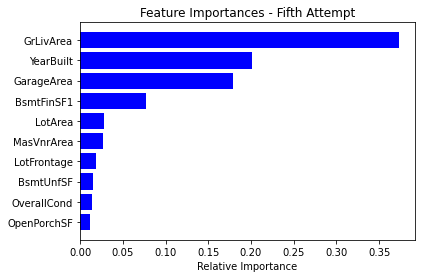

In [61]:
features = train_fifth_attempt_dummy_features.columns
importances = RFRegressor.feature_importances_
indexes = np.argsort(importances)[-10:]  # top 10 features
plt.title("Feature Importances - Fifth Attempt")
plt.barh(range(len(indexes)), importances[indexes], color='b', align='center')
plt.yticks(range(len(indexes)), [features[i] for i in indexes])
plt.xlabel('Relative Importance')
plt.show()

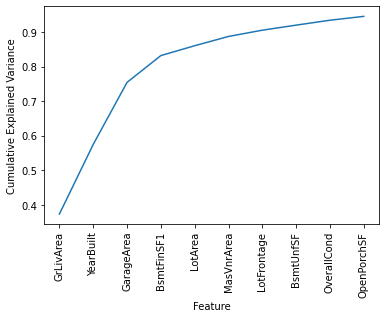

In [62]:
feature_ranking = pd.DataFrame(
    {"Feature": train_fifth_attempt_dummy_features.columns,
     "Weight": RFRegressor.feature_importances_
    }
)
feature_ranking = feature_ranking.sort_values(by=["Weight"], ascending=False).reset_index()
feature_ranking = feature_ranking.drop(["index"], axis=1)
top_features = feature_ranking.head(10)
plt.plot(top_features["Feature"], np.cumsum(top_features["Weight"]))
plt.xticks(top_features["Feature"], top_features["Feature"], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Cumulative Explained Variance');

Now we have a totally new configuration of important variables that will be evaluated in all possible combinations (for top 10 most important)

In [63]:
fifth_attempt_evaluation = evaluate_models(
    data_frame = train_fifth_attempt, 
    features = list(top_features["Feature"].head(10)),
    target_column = "SalePrice",
    initial_number_of_features = 1,
    max_number_of_features = 10
)
(fifth_attempt_evaluation.sort_values(by=["MSE"])).iloc[0:5,:]

Total of evaluations: 5115


,Features,Model,MSE
3451,"[GrLivArea, YearBuilt, BsmtFinSF1, LotFrontage...",DecisionTreeRegressor,40004.946430
2091,"[GrLivArea, YearBuilt, BsmtFinSF1, BsmtUnfSF, ...",DecisionTreeRegressor,40016.234398
2036,"[GrLivArea, YearBuilt, BsmtFinSF1, LotArea, Lo...",DecisionTreeRegressor,40501.624419
3386,"[GrLivArea, YearBuilt, BsmtFinSF1, LotArea, Lo...",DecisionTreeRegressor,40537.430897
4481,"[GrLivArea, YearBuilt, BsmtFinSF1, LotFrontage...",DecisionTreeRegressor,40860.228250


In this final attemp, we got a MSE of 40004.95, a little bit over our fourth and best attempt (38095.35). We are going to submit anyway, to get the score from Kaggle. 

In [64]:
test_set = pd.read_csv("test.csv")
test_set["SalePrice"] = 0 ## Adding a dummy target variable
test_set = null_columns_transformation(test_set, train_set = False)
test_set = replace_ranking_by_rate(test_set)
test_set = standardize_numeric_features(test_set)

prediction_set = generate_predictions(fifth_attempt_evaluation, train_fifth_attempt, test_set)
pd.DataFrame(prediction_set).head()

,0
0,121280.642857
1,156128.571429
2,216380.000000
3,190711.805556
4,180056.358974


In [65]:
generate_submission(test_set, prediction_set, "5th_attempt")

The score of fifth attemp was 0.21245, still around position 3600 of the leaderboard.

## Conclusion

With five attemps of cleansing, standardizing and reducing dimensionality we were able to increase the performance of our project five times (from 0.87504 to 0.21245), which would make us climb around 600 positions on the leaderboard.

<img src="kaggle_submissions.png"> 